The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 实战Kaggle比赛：狗的品种识别（ImageNet Dogs）

本节我们将在Kaggle上实战狗品种识别问题。
本次(**比赛网址是https://www.kaggle.com/c/dog-breed-identification**)。
 :numref:`fig_kaggle_dog`显示了鉴定比赛网页上的信息。
需要一个Kaggle账户才能提交结果。

在这场比赛中，我们将识别120类不同品种的狗。
这个数据集实际上是著名的ImageNet的数据集子集。与 :numref:`sec_kaggle_cifar10`中CIFAR-10数据集中的图像不同，
ImageNet数据集中的图像更高更宽，且尺寸不一。

![狗的品种鉴定比赛网站，可以通过单击“数据”选项卡来获得比赛数据集。](../img/kaggle-dog.jpg)
:width:`400px`
:label:`fig_kaggle_dog`


In [1]:
import os
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 获取和整理数据集

比赛数据集分为训练集和测试集，分别包含RGB（彩色）通道的10222张、10357张JPEG图像。
在训练数据集中，有120种犬类，如拉布拉多、贵宾、腊肠、萨摩耶、哈士奇、吉娃娃和约克夏等。

### 下载数据集

登录Kaggle后，可以点击 :numref:`fig_kaggle_dog`中显示的竞争网页上的“数据”选项卡，然后点击“全部下载”按钮下载数据集。在`../data`中解压下载的文件后，将在以下路径中找到整个数据集：

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test


上述结构与 :numref:`sec_kaggle_cifar10`的CIFAR-10类似，其中文件夹`train/`和`test/`分别包含训练和测试狗图像，`labels.csv`包含训练图像的标签。

同样，为了便于入门，[**我们提供完整数据集的小规模样本**]：`train_valid_test_tiny.zip`。
如果要在Kaggle比赛中使用完整的数据集，则需要将下面的`demo`变量更改为`False`。


In [2]:
#@save
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# 如果使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### [**整理数据集**]

我们可以像 :numref:`sec_kaggle_cifar10`中所做的那样整理数据集，即从原始训练集中拆分验证集，然后将图像移动到按标签分组的子文件夹中。

下面的`reorg_dog_data`函数读取训练数据标签、拆分验证集并整理训练集。


In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## [**图像增广**]

回想一下，这个狗品种数据集是ImageNet数据集的子集，其图像大于 :numref:`sec_kaggle_cifar10`中CIFAR-10数据集的图像。
下面我们看一下如何在相对较大的图像上使用图像增广。


In [4]:
transform_train = gluon.data.vision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    gluon.data.vision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                                   ratio=(3.0/4.0, 4.0/3.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    # 随机更改亮度，对比度和饱和度
    gluon.data.vision.transforms.RandomColorJitter(brightness=0.4,
                                                   contrast=0.4,
                                                   saturation=0.4),
    # 添加随机噪声
    gluon.data.vision.transforms.RandomLighting(0.1),
    gluon.data.vision.transforms.ToTensor(),
    # 标准化图像的每个通道
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

测试时，我们只使用确定性的图像预处理操作。


In [5]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

## [**读取数据集**]

与 :numref:`sec_kaggle_cifar10`一样，我们可以读取整理后的含原始图像文件的数据集。


In [6]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ('train', 'valid', 'train_valid', 'test')]

下面我们创建数据加载器实例的方式与 :numref:`sec_kaggle_cifar10`相同。


In [7]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True,
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False,
    last_batch='keep')

## [**微调预训练模型**]

同样，本次比赛的数据集是ImageNet数据集的子集。
因此，我们可以使用 :numref:`sec_fine_tuning`中讨论的方法在完整ImageNet数据集上选择预训练的模型，然后使用该模型提取图像特征，以便将其输入到定制的小规模输出网络中。
深度学习框架的高级API提供了在ImageNet数据集上预训练的各种模型。
在这里，我们选择预训练的ResNet-34模型，我们只需重复使用此模型的输出层（即提取的特征）的输入。
然后，我们可以用一个可以训练的小型自定义输出网络替换原始输出层，例如堆叠两个完全连接的图层。
与 :numref:`sec_fine_tuning`中的实验不同，以下内容不重新训练用于特征提取的预训练模型，这节省了梯度下降的时间和内存空间。

回想一下，我们使用三个RGB通道的均值和标准差来对完整的ImageNet数据集进行图像标准化。
事实上，这也符合ImageNet上预训练模型的标准化操作。


In [8]:
def get_net(devices):
    finetune_net = gluon.model_zoo.vision.resnet34_v2(pretrained=True)
    # 定义一个新的输出网络
    finetune_net.output_new = nn.HybridSequential(prefix='')
    finetune_net.output_new.add(nn.Dense(256, activation='relu'))
    # 共有120个输出类别
    finetune_net.output_new.add(nn.Dense(120))
    # 初始化输出网络
    finetune_net.output_new.initialize(init.Xavier(), ctx=devices)
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net.collect_params().reset_ctx(devices)
    return finetune_net

在[**计算损失**]之前，我们首先获取预训练模型的输出层的输入，即提取的特征。
然后我们使用此特征作为我们小型自定义输出网络的输入来计算损失。


In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        X_shards, y_shards = d2l.split_batch(features, labels, devices)
        output_features = [net.features(X_shard) for X_shard in X_shards]
        outputs = [net.output_new(feature) for feature in output_features]
        ls = [loss(output, y_shard).sum() for output, y_shard
              in zip(outputs, y_shards)]
        l_sum += sum([float(l.sum()) for l in ls])
        n += labels.size
    return l_sum / n

## 定义[**训练函数**]

我们将根据模型在验证集上的表现选择模型并调整超参数。
模型训练函数`train`只迭代小型自定义输出网络的参数。


In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 只训练小型自定义输出网络
    trainer = gluon.Trainer(net.output_new.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            X_shards, y_shards = d2l.split_batch(features, labels, devices)
            output_features = [net.features(X_shard) for X_shard in X_shards]
            with autograd.record():
                outputs = [net.output_new(feature)
                           for feature in output_features]
                ls = [loss(output, y_shard).sum() for output, y_shard
                      in zip(outputs, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            metric.add(sum([float(l.sum()) for l in ls]), labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
    measures = f'train loss {metric[0] / metric[1]:.3f}'
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## [**训练和验证模型**]

现在我们可以训练和验证模型了，以下超参数都是可调的。
例如，我们可以增加迭代轮数。
另外，由于`lr_period`和`lr_decay`分别设置为2和0.9，
因此优化算法的学习速率将在每2个迭代后乘以0.9。


train loss 0.966, valid loss 0.968
174.7 examples/sec on [gpu(0), gpu(1)]


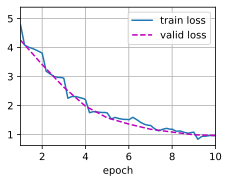

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 5e-3, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## [**对测试集分类**]并在Kaggle提交结果

与 :numref:`sec_kaggle_cifar10`中的最后一步类似，最终所有标记的数据（包括验证集）都用于训练模型和对测试集进行分类。
我们将使用训练好的自定义输出网络进行分类。


train loss 0.907
219.2 examples/sec on [gpu(0), gpu(1)]


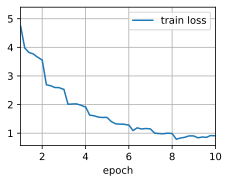

In [12]:
net = get_net(devices)
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output_features = net.features(data.as_in_ctx(devices[0]))
    output = npx.softmax(net.output_new(output_features))
    preds.extend(output.asnumpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.synsets) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

上面的代码将生成一个`submission.csv`文件，以 :numref:`sec_kaggle_house`中描述的方式提在Kaggle上提交。

## 小结

* ImageNet数据集中的图像比CIFAR-10图像尺寸大，我们可能会修改不同数据集上任务的图像增广操作。
* 要对ImageNet数据集的子集进行分类，我们可以利用完整ImageNet数据集上的预训练模型来提取特征并仅训练小型自定义输出网络，这将减少计算时间和节省内存空间。

## 练习

1. 试试使用完整Kaggle比赛数据集，增加`batch_size`（批量大小）和`num_epochs`（迭代轮数），或者设计其它超参数为`lr = 0.01`，`lr_period = 10`，和`lr_decay = 0.1`时，能取得什么结果？
1. 如果使用更深的预训练模型，会得到更好的结果吗？如何调整超参数？能进一步改善结果吗？


[Discussions](https://discuss.d2l.ai/t/2832)
